# Experiment 1

KeyError: 'GradientBoostingClassifier'

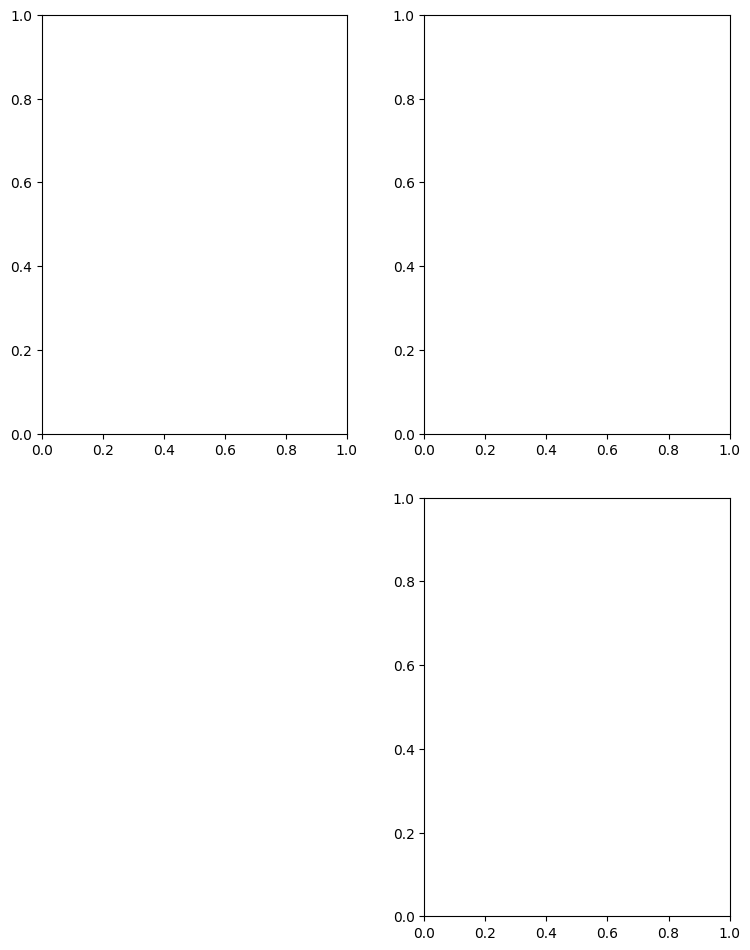

In [3]:
from typing import Literal, Tuple, Union
from average_results import ret_avg_results
import numpy as np
from itertools import product

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

from math import ceil

def plot_results(datasets=['mnist', 'covertype', 'yeast', 'skin', 'statlog'],
                 plot_type:Literal['acc', 'time']='acc',
                 knn_algo:Literal['brute', 'kd_tree', 'ball_tree']='brute',
                 omit_baseline_x=False,
                 omit_baseline_gnb=False,
                 omit_thresholds:Union[None, Tuple[float]]=None
                 ):
    
    ret = ret_avg_results(datasets=datasets, knn_algo=knn_algo)
    if ret is None:
        print("No results found")
        return
    
    datasets = ret.keys()

    col_amount = min(2, len(datasets)+1)

    q = len(datasets)//col_amount
    r = len(datasets)%col_amount

    row_amount = q+1
    fig, axs = plt.subplots(row_amount, col_amount,figsize=(8, 10))
    fig.tight_layout(pad=2.5)


    if row_amount==1:
        axs = np.array([axs], dtype=object)

    for i in range(r, col_amount-1):
        axs[-1][i].set_visible(False)

    clfs= ret[list(datasets)[0]]["clfs"]

    ax = plt.gca()
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    clfs_map = {
        'DecisionTreeClassifier':'Decision Tree',
        'GaussianNB': 'Gaussian Naive Bayes',
        'LogisticRegression': 'Logistic Regression',
        'SVC': 'SVM',
        'KNN': 'KNN'
    }

    patches_clf = [mlines.Line2D(xdata=[0], ydata=[0], color=colors[i%len(clfs+['KNN'])], linestyle='solid', label=clfs_map[clf]) for i,clf in enumerate(clfs+ ['KNN'])]
    patches_smart = [mlines.Line2D(xdata=[0], ydata=[0], color='black', linestyle='dashed', label='Baseline X')]

    handles = patches_clf + patches_smart

    dataset_map = {
        'wine': 'Wine Quality',
        'mnist': 'MNIST',
        'usps': 'USPS',
        'glass': 'Glass Identification',
        'yeast': 'Yeast',
        'covertype': 'Covertype',
        'statlog': 'Statlog (Shuttle)',
        'skin': 'Skin Segmentation'
    }

    for i, dataset in enumerate(sorted(datasets)):
        results_dict = ret[dataset]

        baseline_knn= results_dict[f"baseline_knn_{plot_type}"]
        baseline= results_dict[f"baseline_{plot_type}"]
        smart= results_dict[f"smart_{plot_type}"]

        smart = np.swapaxes(smart, 1, 2)

        clfs= results_dict["clfs"]
        ks= results_dict['ks']
        default_k_ticks = range(len(ks))
        thresholds= results_dict['thresholds']

        curr_ax = axs[i//col_amount, i%col_amount]

        curr_ax.set_title(f"{dataset_map[dataset]}")
        curr_ax.plot(default_k_ticks, baseline_knn, label="KNN", linestyle='solid', color=colors[len(clfs)])
        curr_ax.set_xticks(default_k_ticks, ks, rotation=90)

        curr_ax.grid(True)

        if not omit_baseline_x:
            for (iclf, clf) in enumerate(clfs):
                if omit_baseline_gnb and 'gaussian' in clf.lower():
                    continue

                if baseline[iclf] >= min(baseline_knn):
                    curr_ax.axhline(y=baseline[iclf], label=f'{clf}', color=colors[iclf%len(clfs)], linestyle='dashed')

        thresholds_enum = enumerate(thresholds)
        if omit_thresholds is not None:
            thresholds_enum = list(filter(lambda tup: tup[1] not in omit_thresholds, thresholds_enum))

        line_styles = ['solid', 'dashed', 'dotted', 'dashdot', (0, (1,1))]
        line_styles_it = iter(line_styles)
        line_styles_dict = {t: next(line_styles_it) for i,t in thresholds_enum}
        patches_t = [mlines.Line2D(xdata=[0], ydata=[0], color='black', linestyle=line_styles_dict[threshold], label=threshold) for i,threshold in thresholds_enum]
        patches_t = []

        for (iclf, clf), (it, threshold) in product(enumerate(clfs), thresholds_enum):
            if omit_thresholds is not None and threshold in omit_thresholds:
                continue

            curr = smart[iclf, it]
            curr_ax.plot(default_k_ticks, curr, color=colors[iclf%len(clfs)], linestyle=line_styles_dict[threshold])

    axs[-1][-1].axis('off')

    fig.legend(handles=handles+patches_t, loc='lower center',  bbox_to_anchor=(0, 0.05, 1.05, 0))

    fig.suptitle("Experiment 1 - KNN vs KNN+X vs X", fontsize=20)
    fig.subplots_adjust(top=0.92)
    plt.show()

plot_results(datasets=['covertype', 'glass', 'mnist', 'skin','statlog', 'usps', 'wine', 'yeast'], plot_type='acc',knn_algo='brute', omit_baseline_x=False, omit_baseline_gnb=True, omit_thresholds=(0.6,0.8,0.9,0.95))